Structured variational message passing demo
===

A generalization of VMP under the mean field approximation is structured VMP (SVMP). SVMP allows arbitrary factorizations of the approximating $q$ distribution (Dauwels 2007). As an example case to illustrate and test our SVMP implementation in ForneyLab, we estimate the mean $m$ and precision $\gamma$ for a set of samples $y = \{y_1, ..., y_k, ..., y_n\}$ drawn from a Gaussian distribution.

The factor graph below shows our generative model, where we use the notation of (Reller, 2012; State-space methods in statistical signal processing). Filled black nodes represent observed variables and dotted arcs denote the repetition of a section.

<img src="images/gauss_est_prec.png">

This is the same model as in the previous demo, however this time we use precision parametrization and factorize the approximating distribution as $q(m,\gamma,y)=q(m,\gamma)\,q(y)$. Also, we estimate the mean and precision in a sample-by sample (online) fashion instead of in bulk.

We begin by implementing the factor graph in ForneyLab and define the structured factoriation.

In [1]:
using(ForneyLab)

# Initialize nodes and edges
g_node = GaussianNode(name="g_node", form=:precision)
m_eq_node = EqualityNode(name="m_eq_node") # Equality node for mean
gam_eq_node = EqualityNode(name="gam_eq_node") # Equality node for precision
y_node = TerminalNode(name="y_node") # Observed y values are stored in y_node
m_n_min_1_node = PriorNode(GaussianDistribution(m=0.0, V=100.0), name="m_n_min_1") # Prior
gam_n_min_1_node = PriorNode(GammaDistribution(a=0.01, b=0.01), name="gam_n_min_1") # Prior
m_n_node = TerminalNode(vague(GaussianDistribution), name="m_n")
gam_n_node = TerminalNode(vague(GammaDistribution), name="gam_n")

Edge(g_node.i[:out], y_node, GaussianDistribution)
Edge(m_eq_node.i[3], g_node.i[:mean], GaussianDistribution)
Edge(gam_eq_node.i[3], g_node.i[:precision], GammaDistribution)
Edge(m_n_min_1_node, m_eq_node.i[1], GaussianDistribution)
Edge(gam_n_min_1_node, gam_eq_node.i[1], GammaDistribution)
Edge(m_eq_node.i[2], m_n_node, GaussianDistribution)
Edge(gam_eq_node.i[2], gam_n_node, GammaDistribution)

# Set wraps
wrap(m_n_node, m_n_min_1_node)
wrap(gam_n_node, gam_n_min_1_node);

Now we need to specify the factorization, update schedules for both subgraphs and set the vague (almost uninformative) marginals.


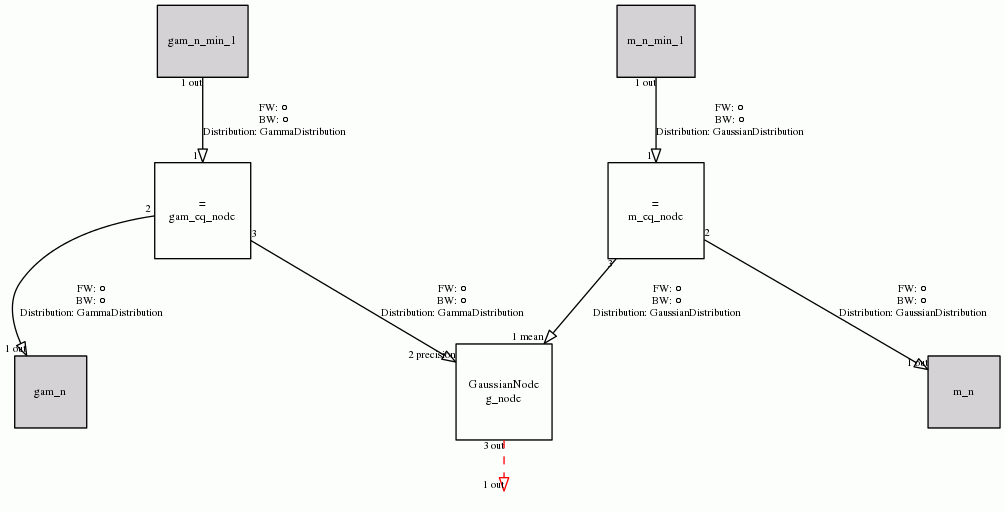


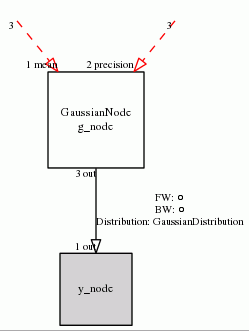

In [2]:
# Generate some data
true_mean = 5.0
true_prec = 0.5
n_samples = 100 # Draw 100 samples
n_its = 10 # Iterations per data sample
y_vals = randn(n_samples)*(1/sqrt(true_prec))+true_mean
data = [DeltaDistribution(y) for y in y_vals]

# Add read and write buffers
y_buffer = setReadBuffer(y_node, data)
m_est = setWriteBuffer(m_eq_node.i[2])
gam_est = setWriteBuffer(gam_eq_node.i[2])

# Define the structured variational algorithm
algo = VMP.Algorithm(Set{Edge}({g_node.i[:out].edge}), n_iterations=n_its)

# Inspect the factorization (optional)
for subgraph in algo.fields[:factorization].factors
    draw(subgraph)
end

Now the setup is done and we can start the iterations.

In [3]:
run(algo)

Let's inspect the results.

In [4]:
println("True mean: $(true_mean)")
println("True precision: $(true_prec)")
println("Number of samples: $(n_samples)")
println("Sample mean: $(round(mean(y_vals),2))")
println("Sample precision: $(round(1/var(y_vals),2))")
println("\n----- Online estimation after $(n_its) VMP updates per sample -----")
println("Mean estimate: $(round(mean(m_est[end])[1],2)), with variance $(round(var(m_est[end])[1,1],2))")
println("Precision estimate: $(round(mean(gam_est[end]),2)), with variance $(round(var(gam_est[end]),2))")

True mean: 5.0
True precision: 0.5
Number of samples: 100
Sample mean: 5.01
Sample precision: 0.56

----- Online estimation after 10 VMP updates per sample -----
Mean estimate: 4.99, with variance 0.03
Precision estimate: 0.44, with variance 0.0
